# INLP - Assignment 2
## Harshavardhan P - 2021111003

In [50]:
import torch
import torch.nn as nn
import conllu
import pandas as pd
import gensim.downloader as api
from torch.utils.data import Dataset, DataLoader
import pprint as pp
import numpy as np
import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
device = ''
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = torch.device("cpu")
print(device)

cpu


# Flow - 1

## Dataset

### Importing data file

In [4]:
# import the data files
dataset_path_train = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu'
dataset_path_dev = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu'
dataset_path_test = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu'

dataset_train = conllu.parse_incr(open(dataset_path_train))
dataset_dev = conllu.parse_incr(open(dataset_path_dev))
dataset_test = conllu.parse_incr(open(dataset_path_test))

# create a dataframe from the data
def create_dataframe(dataset):
    data = []
    for tokenlist in dataset:
        for token in tokenlist:
            # data.append([token['form'], token['upostag']])
            data.append([token['id'], token['form'], token['upostag']])
    # return pd.DataFrame(data, columns=['', 'word', 'pos'])
    return pd.DataFrame(data, columns=['id', 'word', 'pos'])

df_train = create_dataframe(dataset_train)
df_dev = create_dataframe(dataset_dev)
df_test = create_dataframe(dataset_test)

print(df_train.head())
print(df_dev.head())
print(df_test.head())

   id  word   pos
0   1  what  PRON
1   2    is   AUX
2   3   the   DET
3   4  cost  NOUN
4   5    of   ADP
   id      word   pos
0   1         i  PRON
1   2     would   AUX
2   3      like  VERB
3   4       the   DET
4   5  cheapest   ADJ
   id     word   pos
0   1     what  PRON
1   2      are   AUX
2   3      the   DET
3   4    coach  NOUN
4   5  flights  NOUN


In [5]:
df = df_train
vocab = set(df['word'])
pos_tags = set(df['pos'])
word_vectors_all = api.load('glove-wiki-gigaword-100')

### Preprocess the data

In [6]:
# function to find vocabulary and POS tags, as well as load the word embeddings to be used
def preprocess_train(df, p=3, s=3, embedding_type='glove-wiki-gigaword-100'):
    vocab = set(df['word'])
    pos_tags = set(df['pos'])
    word_vectors_all = api.load(embedding_type)

    word_vectors = {}
    for word in vocab:
        if word in word_vectors_all:
            word_vectors[word] = word_vectors_all[word]
        else:
            word_vectors[word] = torch.zeros(len(word_vectors_all['the']))

    # one hot encode the POS tags
    pos_tags_one_hot = {}
    for i, tag in enumerate(pos_tags):
        one_hot = torch.zeros(len(pos_tags) + 1)
        one_hot[i] = 1
        pos_tags_one_hot[tag] = one_hot
    pos_tags_one_hot[''] = torch.zeros(len(pos_tags) + 1)
    pos_tags_one_hot[''][-1] = 1

    # convert the df to list
    data = df.values.tolist()
    dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
    # pp.pprint(dataset)

    max = 0
    for i in range(len(dataset)):
        if data[i][0] > max:
            max = data[i][0]

    split_dataset = []
    curr = 0
    for i in range(1, len(dataset)):
        if data[i][0] == 1:
            split_dataset.append(dataset[curr:i])
            curr = i
    split_dataset.append(dataset[curr:])
    # print(len(split_dataset))
    # print(max)

    final_dataset = []
    for i in range(len(split_dataset)):
        dataset = split_dataset[i]
        dataset1 = dataset.copy()
        dataset2 = dataset.copy()
        for j in range(p):
            dataset1 = dataset1[:-1]
            dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
            dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
        for j in range(s):
            dataset2 = dataset2[1:]
            dataset2 = np.append(dataset2, [np.zeros(len(word_vectors_all['the']))], axis=0)
            dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
        final_dataset.append(dataset)

    # pp.pprint(final_dataset[0][0])
    # pp.pprint(final_dataset[0][-1])

    dataset = []
    for lst in final_dataset:
        dataset.extend(lst)
    dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
    print(dataset.shape)

    final_dataset = []
    for i in range(len(dataset)):
        final_dataset.append([torch.tensor(dataset[i][0]), pos_tags_one_hot[data[i][2]]])

    print(len(final_dataset))
    print(len(final_dataset[0]))
    print(len(final_dataset[0][0]))
    print(len(final_dataset[0][1]))
    # print(type(final_dataset[0][0]))
    # print(type(final_dataset[0][1]))
    # print(final_dataset[22][0])
    # print(final_dataset[0][1])

    return final_dataset, word_vectors, pos_tags_one_hot

In [7]:
# function to preprocess the dev and test data, using the word vectors and POS tags from the training data
def preprocess_dev_test(df, word_vectors, pos_tags_one_hot, p=3, s=3):
    data = df.values.tolist()
    # dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
    dataset = []
    for i in range(len(data)):
        if data[i][1] in word_vectors:
            dataset.append(word_vectors[data[i][1]])
        else:
            dataset.append(torch.zeros(len(word_vectors['the'])))
    dataset = np.array(dataset, dtype=np.float32)
    # pp.pprint(dataset)

    max = 0
    for i in range(len(dataset)):
        if data[i][0] > max:
            max = data[i][0]

    split_dataset = []
    curr = 0
    for i in range(1, len(dataset)):
        if data[i][0] == 1:
            split_dataset.append(dataset[curr:i])
            curr = i
    split_dataset.append(dataset[curr:])
    # print(len(split_dataset))
    # print(max)

    final_dataset = []
    for i in range(len(split_dataset)):
        dataset = split_dataset[i]
        dataset1 = dataset.copy()
        dataset2 = dataset.copy()
        for j in range(p):
            dataset1 = dataset1[:-1]
            dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors['the']))], axis=0)
            dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
        for j in range(s):
            dataset2 = dataset2[1:]
            dataset2 = np.append(dataset2, [np.zeros(len(word_vectors['the']))], axis=0)
            dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
        final_dataset.append(dataset)

    # pp.pprint(final_dataset[0][0])
    # pp.pprint(final_dataset[0][-1])

    dataset = []
    for lst in final_dataset:
        dataset.extend(lst)
    dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
    print(dataset.shape)

    final_dataset = []
    for i in range(len(dataset)):
        # final_dataset.append([torch.tensor(dataset[i][0]), pos_tags_one_hot[data[i][2]]])
        tensor1 = torch.tensor(dataset[i][0])
        try:
            tensor2 = pos_tags_one_hot[data[i][2]]
        except:
            tensor2 = pos_tags_one_hot['']
        final_dataset.append([tensor1, tensor2])

    print(len(final_dataset))
    print(len(final_dataset[0]))
    print(len(final_dataset[0][0]))
    print(len(final_dataset[0][1]))
    # print(type(final_dataset[0][0]))
    # print(type(final_dataset[0][1]))
    # print(final_dataset[22][0])
    # print(final_dataset[0][1])

    return final_dataset

### Creating Dataset and loading

In [8]:
class CoNLLUDataset(Dataset):
    def __init__(self, data):
        self.dataset = data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # input_tensor = torch.tensor(self.dataset[idx][0], dtype=torch.float32, device=device)
        input_tensor = self.dataset[idx][0].to(device)
        # target_tensor = torch.tensor(self.dataset[idx][1], dtype=torch.float32, device=device)
        target_tensor = self.dataset[idx][1].to(device)
        return input_tensor, target_tensor

In [9]:
# preprocess the data
train_data, word_vectors, pos_tags_one_hot = preprocess_train(df_train)
dev_data = preprocess_dev_test(df_dev, word_vectors, pos_tags_one_hot)
test_data = preprocess_dev_test(df_test, word_vectors, pos_tags_one_hot)

# create the dataloaders
train_conllu_dataset = CoNLLUDataset(train_data)
dev_conllu_dataset = CoNLLUDataset(dev_data)
test_conllu_dataset = CoNLLUDataset(test_data)

train_dataloader = DataLoader(train_conllu_dataset, batch_size=64, shuffle=True)
dev_dataloader = DataLoader(dev_conllu_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_conllu_dataset, batch_size=64, shuffle=True)

(48655, 1, 700)
48655
2
700
14
(6644, 1, 700)
6644
2
700
14
(6580, 1, 700)
6580
2
700
14


## Models

### FNN

In [10]:
# creating an FNN which takes n dim input and returns pos tag vector
class FNN(nn.Module):
    def __init__(self, embed_dim, prev_n, succ_n, hidden_params, output_dim):
        super(FNN, self).__init__()
        # for each element in hidden_params, we will create a linear layer
        hidden_layers = []
        hidden_layers.append(nn.Linear(embed_dim * (prev_n + 1 + succ_n), hidden_params[0]))
        hidden_layers.append(nn.ReLU())
        for i in range(1, len(hidden_params)):
            hidden_layers.append(nn.Linear(hidden_params[i-1], hidden_params[i]))
            hidden_layers.append(nn.ReLU())
        # softmax layer for output
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(hidden_params[-1], output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

### RNN

In [11]:
# creating an RNN which takes n dim input and returns pos tag vector
class RNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

## Training

Epoch 1


100%|██████████| 761/761 [00:01<00:00, 517.00it/s]


Epoch 1, loss: 0.03351430920578059
Epoch 2


100%|██████████| 761/761 [00:01<00:00, 595.60it/s]


Epoch 2, loss: 0.013180957747312476
Epoch 3


100%|██████████| 761/761 [00:01<00:00, 564.47it/s]


Epoch 3, loss: 0.011306621873158956


100%|██████████| 103/103 [00:00<00:00, 1152.50it/s]



Loss: 0.0120525477664292

Accuracy: 0.9756838905775076
Precision: 0.9754318772132632
Recall: 0.9756838905775076
F1 Score: 0.9752996708843468


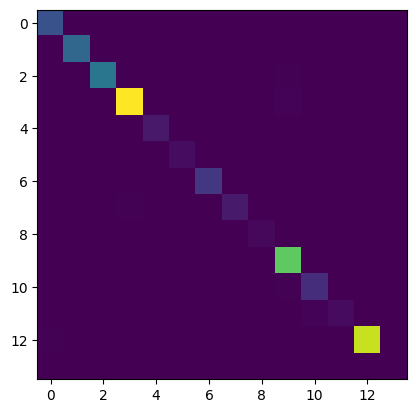

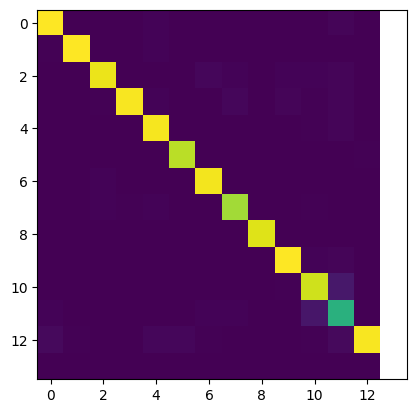

100%|██████████| 104/104 [00:00<00:00, 978.73it/s]



Loss: 0.01390953288332989

Accuracy: 0.9697471402769416
Precision: 0.9697908266417944
Recall: 0.9697471402769416
F1 Score: 0.9693767335213349


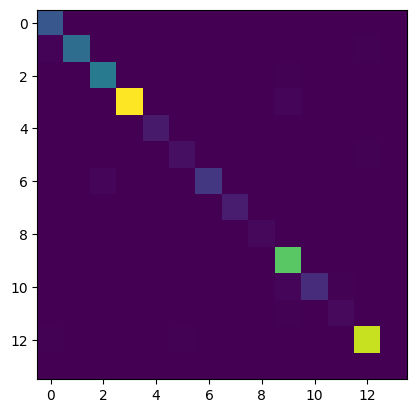

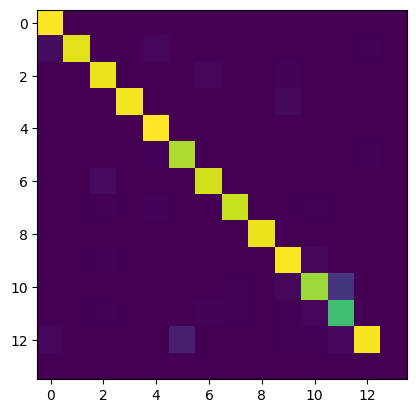

In [55]:
# Loss for classification
criterion = nn.BCELoss()

# function to train the model
def train_model(model, dataloader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        running_loss = 0.0
        # for i, data in enumerate(dataloader, 0):
        for i, data in enumerate(tqdm.tqdm(dataloader, position=0, leave=True), 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(dataloader)}")

# function to test the model
def test_model(model, dataloader, criterion, pos_tags_one_hot):
    # find loss, accuracy, precision, recall, f1 score
    model.eval()
    running_loss = 0.0
    total_outputs = []
    total_labels = []
    with torch.no_grad():
        # for data in dataloader:
        for data in tqdm.tqdm(dataloader, position=0, leave=True):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, actual = torch.max(labels, 1)
            outputs_copy = outputs.clone().detach().cpu().numpy()
            outputs_one_hot = np.zeros(outputs_copy.shape)
            outputs_one_hot[np.arange(outputs_copy.shape[0]), np.argmax(outputs_copy, axis=1)] = 1

            total_outputs.extend(outputs_one_hot)
            total_labels.extend(labels.clone().detach().cpu().numpy())

    total_outputs = np.array(total_outputs)
    total_labels = np.array(total_labels)
    print()
    print(f"Loss: {running_loss/len(dataloader)}")
    print()
    print(f"Accuracy: {accuracy_score(total_labels, total_outputs)}")
    print(f"Precision: {precision_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
    print(f"Recall: {recall_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
    print(f"F1 Score: {f1_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
    confusion_matrix = np.zeros((len(pos_tags_one_hot), len(pos_tags_one_hot)))
    for i in range(len(total_labels)):
        actual = np.argmax(total_labels[i])
        predicted = np.argmax(total_outputs[i])
        confusion_matrix[actual][predicted] += 1
    confusion_matrix2 = confusion_matrix / np.sum(confusion_matrix, axis=1)
    plt.imshow(confusion_matrix)
    plt.show()
    plt.imshow(confusion_matrix2)
    plt.show()

# train and test the FNN model
fnn_model = FNN(100, 3, 3, [100], len(pos_tags_one_hot)).to(device)
optimizer = torch.optim.Adam(fnn_model.parameters(), lr=0.001, weight_decay=0.0001)
train_model(fnn_model, train_dataloader, 3, optimizer, criterion)
test_model(fnn_model, test_dataloader, criterion, pos_tags_one_hot)
test_model(fnn_model, dev_dataloader, criterion, pos_tags_one_hot)

## Evaluation

# Experimentations

## Importing Dataset

In [ ]:
# import conllu from dataset paths
dataset_path_train = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu'
dataset_path_dev = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu'
dataset_path_test = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu'

dataset_train = conllu.parse_incr(open(dataset_path_train))
dataset_dev = conllu.parse_incr(open(dataset_path_dev))
dataset_test = conllu.parse_incr(open(dataset_path_test))

print("Number of sentences in training dataset: ", len(list(dataset_train)))
print("Number of sentences in dev dataset: ", len(list(dataset_dev)))
print("Number of sentences in test dataset: ", len(list(dataset_test)))

Number of sentences in training dataset:  4274
Number of sentences in dev dataset:  572
Number of sentences in test dataset:  586


In [ ]:
# bring the pointer back to the beginning of the file
dataset_train = conllu.parse_incr(open(dataset_path_train))
dataset_dev = conllu.parse_incr(open(dataset_path_dev))
dataset_test = conllu.parse_incr(open(dataset_path_test))

# convert this data to a pandas dataframe
def conllu_to_pandas(dataset):
    data = []
    for tokenlist in dataset:
        for token in tokenlist:
            data.append(token)
    return pd.DataFrame(data)

df_train = conllu_to_pandas(dataset_train)
df_dev = conllu_to_pandas(dataset_dev)
df_test = conllu_to_pandas(dataset_test)

print(df_train.head())

   id  form lemma  upos  xpos  \
0   1  what  what  PRON  None   
1   2    is    be   AUX  None   
2   3   the   the   DET  None   
3   4  cost  cost  NOUN  None   
4   5    of    of   ADP  None   

                                               feats  head deprel  deps  misc  
0                            {'PronType': 'Int,Rel'}     0   root  None  None  
1  {'Mood': 'Ind', 'Number': 'Sing', 'Person': '3...     1    cop  None  None  
2                                {'PronType': 'Art'}     4    det  None  None  
3                                 {'Number': 'Sing'}     1  nsubj  None  None  
4                                               None     7   case  None  None  


## Embedding

### Finding vocab

In [ ]:
# create vocabulary of the words in the training set
vocab = df_train['form'].unique()
print("Number of unique words in the training set: ", len(vocab))

Number of unique words in the training set:  863


In [ ]:
# add <s>, </s> and <unk> to the vocabulary
vocab = ['<s>', '</s>', '<unk>'] + list(vocab)
print("Number of unique words in the training set after adding <s>, </s>, <unk>: ", len(vocab))

Number of unique words in the training set after adding <s>, </s>, <unk>:  866


In [ ]:
# finding all unique pos tags
upos = df_train['upos'].unique()
print("Number of unique upos in the training set: ", len(upos))
print(upos)

Number of unique upos in the training set:  13
['PRON' 'AUX' 'DET' 'NOUN' 'ADP' 'PROPN' 'VERB' 'NUM' 'ADJ' 'CCONJ' 'ADV'
 'PART' 'INTJ']


In [ ]:
# adding pos tags for <s>, </s>, <unk> to the upos
upos = ['STRT', 'END', 'UNK'] + list(upos)

print("Number of unique upos in the training set after adding STRT, END, UNK: ", len(upos))

Number of unique upos in the training set after adding STRT, END, UNK:  16


### Embedding layer

In [ ]:
# for the vocab, we must create a nn embedding
# we will use the nn.Embedding class from pytorch

# create a dictionary to map words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
print(word_to_idx)

embedding = nn.Embedding(len(vocab), 100, device=device)
print(embedding)

# create a tensor of indices for the words in the first sentence
sentence = df_train[df_train['id'] == 1]
print(len(sentence))
# print(sentence)

word_indices = [word_to_idx.get(word, word_to_idx['<unk>']) for word in sentence['form']]
print(word_indices)

word_indices = torch.tensor(word_indices, dtype=torch.long, device=device)
print(word_indices)

# pass the tensor of indices to the embedding
embedded = embedding(word_indices)
print(embedded)
print(embedded.shape)

{'<s>': 0, '</s>': 1, '<unk>': 2, 'what': 3, 'is': 4, 'the': 5, 'cost': 6, 'of': 7, 'a': 8, 'round': 9, 'trip': 10, 'flight': 11, 'from': 12, 'pittsburgh': 13, 'to': 14, 'atlanta': 15, 'beginning': 16, 'on': 17, 'april': 18, 'twenty': 19, 'fifth': 20, 'and': 21, 'returning': 22, 'may': 23, 'sixth': 24, 'now': 25, 'i': 26, 'need': 27, 'leaving': 28, 'fort': 29, 'worth': 30, 'arriving': 31, 'in': 32, 'denver': 33, 'no': 34, 'later': 35, 'than': 36, '2': 37, 'pm': 38, 'next': 39, 'monday': 40, 'fly': 41, 'kansas': 42, 'city': 43, 'chicago': 44, 'wednesday': 45, 'following': 46, 'day': 47, 'meaning': 48, 'meal': 49, 'code': 50, 's': 51, 'show': 52, 'me': 53, 'all': 54, 'flights': 55, 'which': 56, 'serve': 57, 'for': 58, 'after': 59, 'tomorrow': 60, 'us': 61, 'air': 62, 'list': 63, 'nonstop': 64, 'early': 65, 'tuesday': 66, 'morning': 67, 'dallas': 68, 'st.': 69, 'petersburg': 70, 'toronto': 71, 'that': 72, 'arrive': 73, 'listing': 74, 'new': 75, 'york': 76, 'montreal': 77, 'canada': 78, 'd

### Word2Vec embedding

In [ ]:
# load the pre-trained word2vec model - wiki 100
word2vec = api.load("glove-wiki-gigaword-100")
print('loaded')
print(word2vec['king'])

loaded
[-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

## Changing label rep. to one-hot

In [ ]:
# change the pos tags to one-hot vectors


## Creating torch dataset

In [ ]:
class CoNLLUDataset(Dataset):
    def __init__(self, conllu_file):
        self.data = self.load_conllu(conllu_file)

    def load_conllu(self, conllu_file):
        dataset = conllu.parse_incr(open(conllu_file))
        data = []
        for tokenlist in dataset:
            for token in tokenlist:
                data.append(token)
        dataset = pd.DataFrame(data)
        # only retain the columns form and upos
        dataset = dataset[['form', 'upos']]
        # convert dataset to normal list
        dataset = dataset.values.tolist()
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# print a element in the dataset
dataset = CoNLLUDataset(dataset_path_train)
print(dataset[0])

['what', 'PRON']


In [ ]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=False)

In [ ]:
# function to find vocabulary and POS tags, as well as load the word embeddings to be used
def preprocess_train(df, p=3, s=3, embedding_type='glove-wiki-gigaword-100'):
    vocab = set(df['word'])
    pos_tags = set(df['pos'])
    word_vectors_all = api.load(embedding_type)

    word_vectors = {}
    for word in vocab:
        if word in word_vectors_all:
            word_vectors[word] = word_vectors_all[word]
        else:
            word_vectors[word] = torch.zeros(len(word_vectors_all['the']))

    # one hot encode the POS tags
    pos_tags_one_hot = {}
    for i, tag in enumerate(pos_tags):
        one_hot = torch.zeros(len(pos_tags))
        one_hot[i] = 1
        pos_tags_one_hot[tag] = one_hot

    # # convert the df to list
    # data = df.values.tolist()
    # dataset = []
    # for i in range(len(data)):
    #     vector = []
    #     for j in range(p):
    #         if i - j >= 0:
    #             vector.append(data[i - j][0])
    #         else:
    #             vector.append(torch.zeros(len(word_vectors_all['the'])))
    #     # for j in range(s):

    #     dataset.append([word_vectors[data[i][0]], pos_tags_one_hot[data[i][1]]])

    # convert the df to list
    data = df.values.tolist()
    dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
    # pp.pprint(dataset)

    # make copies of the np.array
    dataset1 = dataset.copy()
    dataset2 = dataset.copy()

    for i in range(p):
        dataset1 = dataset1[:-1]
        dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
        # extend the ith element of the dataset with the ith element of dataset1
        dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)

    for i in range(s):
        dataset2 = dataset2[1:]
        dataset2 = np.insert(dataset2, -1, [np.zeros(len(word_vectors_all['the']))], axis=0)
        # extend the ith element of the dataset with the ith element of dataset1
        dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)

    print(dataset.shape)

    return dataset, word_vectors, pos_tags_one_hot

In [228]:
word_vectors = {}
for word in vocab:
    if word in word_vectors_all:
        word_vectors[word] = word_vectors_all[word]
    else:
        word_vectors[word] = torch.zeros(len(word_vectors_all['the']))

# one hot encode the POS tags
pos_tags_one_hot = {}
for i, tag in enumerate(pos_tags):
    one_hot = torch.zeros(len(pos_tags))
    one_hot[i] = 1
    pos_tags_one_hot[tag] = one_hot

data = df.values.tolist()
dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
# pp.pprint(dataset)

# make copies of the np.array
dataset1 = dataset.copy()
dataset2 = dataset.copy()

for i in range(3):
    dataset1 = dataset1[:-1]
    dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
    # extend the ith element of the dataset with the ith element of dataset1
    dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)

for i in range(3):
    dataset2 = dataset2[1:]
    dataset2 = np.insert(dataset2, -1, [np.zeros(len(word_vectors_all['the']))], axis=0)
    # extend the ith element of the dataset with the ith element of dataset1
    dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)

print(dataset.shape)

(48655, 700)


In [284]:
data = df.values.tolist()

dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
# pp.pprint(dataset)

# find max value of the dataset's elements 0th index
max = 0
for i in range(len(dataset)):
    if data[i][0] > max:
        max = data[i][0]

split_dataset = []
curr = 0
for i in range(1, len(dataset)):
    if data[i][0] == 1:
        split_dataset.append(dataset[curr:i])
        curr = i
split_dataset.append(dataset[curr:])
print(len(split_dataset))
print(max)

final_dataset = []
for i in range(len(split_dataset)):
    dataset = split_dataset[i]
    dataset1 = dataset.copy()
    dataset2 = dataset.copy()
    for j in range(3):
        dataset1 = dataset1[:-1]
        dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
        dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
    for j in range(3):
        dataset2 = dataset2[1:]
        dataset2 = np.insert(dataset2, -1, [np.zeros(len(word_vectors_all['the']))], axis=0)
        dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
    final_dataset.append(dataset)

dataset = []
for lst in final_dataset:
    dataset.extend(lst)
dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
print(dataset.shape)

4274
46
(48655, 1, 700)
<class 'numpy.ndarray'>


## Models

### FNN

In [ ]:
# creating a FNN which takes n dim input and returns pos tag
class FNN(nn.Module):
    def __init__(self, embed_dim, prev_n, succ_n, hidden_params, output_dim):
        super(FNN, self).__init__()
        # for each element in hidden_params, we will create a linear layer
        hidden_layers = []
        hidden_layers.append(nn.Linear(embed_dim * (prev_n + 1 + succ_n), hidden_params[0]))
        hidden_layers.append(nn.ReLU())
        for i in range(1, len(hidden_params)):
            hidden_layers.append(nn.Linear(hidden_params[i-1], hidden_params[i]))
            hidden_layers.append(nn.ReLU())
        # softmax layer for output
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(hidden_params[-1], output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

# create a model
input_dim = 100
hidden_params = [100, 50]
